# Quantum Mechine Learning (QML)

# #1. Quantum Neural Network for Regression

In [1]:
# Impor librari
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# QNN
import time
from IPython.display import clear_output
from qiskit import Aer, QuantumCircuit, transpile, assemble
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit.library import EfficientSU2
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit.visualization import plot_histogram, plot_bloch_multivector

from scipy.optimize import minimize

/var/folders/nd/s6snn9l53zg5sthh_ttcvdpr0000gn/T/ipykernel_1205/2889065652.py:22: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


In [2]:
# Impor dataset
data = pd.read_excel('Concrete.xlsx')
x = data[['Cement', 'Blast']] 
y = data['Strength']  

# Normalisasi
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Split data
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42) # HoldOut Cross-Validation

# QC
def quantum_circuit(params, x):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.h(1)
    qc.ry(params[0] * x[0], 0)
    qc.ry(params[1] * x[1], 1)
    qc.cx(0, 1)
    return qc

# Objective function
def objective_function(params):
    total_loss = 0
    for i in range(len(x_train)):
        qc = quantum_circuit(params, x_train[i])
        qc.measure_all()
        t_qc = transpile(qc, Aer.get_backend('qasm_simulator'))
        qobj = assemble(t_qc, shots=1024)
        result = Aer.get_backend('qasm_simulator').run(qobj).result()
        counts = result.get_counts()
        expected_value = sum(int(key, 2) * counts.get(key, 0) for key in counts) / 1024
        loss = (expected_value - y_train.iloc[i])**2
        total_loss += loss
    return total_loss

# Initial parameter
initial_params = [0.1, 0.1]

# Optimasi QC parameter
opt_result = minimize(objective_function, initial_params, method='COBYLA', options={'maxiter': 500, 'tol': 0.0001})
opt_params = opt_result.x

# Predik dengan parameter
y_pred_tr = []
y_pred_ts = []

for i in range(len(x_train)):
    qc = quantum_circuit(opt_params, x_train[i])
    qc.measure_all()
    t_qc = transpile(qc, Aer.get_backend('qasm_simulator'))
    qobj = assemble(t_qc, shots=1024)
    result = Aer.get_backend('qasm_simulator').run(qobj).result()
    counts = result.get_counts()
    expected_value = sum(int(key, 2) * counts.get(key, 0) for key in counts) / 1024
    y_pred_tr.append(expected_value)

for i in range(len(x_test)):
    qc = quantum_circuit(opt_params, x_test[i])
    qc.measure_all()
    t_qc = transpile(qc, Aer.get_backend('qasm_simulator'))
    qobj = assemble(t_qc, shots=1024)
    result = Aer.get_backend('qasm_simulator').run(qobj).result()
    counts = result.get_counts()
    expected_value = sum(int(key, 2) * counts.get(key, 0) for key in counts) / 1024
    y_pred_ts.append(expected_value)

# Evaluasi model
r2_tr   = r2_score(y_train, y_pred_tr)
rmse_tr = np.sqrt(mean_squared_error(y_train, y_pred_tr))
r2_ts   = r2_score(y_test, y_pred_ts)
rmse_ts = np.sqrt(mean_squared_error(y_test, y_pred_ts))

print("R-squared:", r2_tr)
print("RMSE:", rmse_tr)
print("R-squared:", r2_ts)
print("RMSE:", rmse_ts)

FileNotFoundError: [Errno 2] No such file or directory: 'Concrete.xlsx'

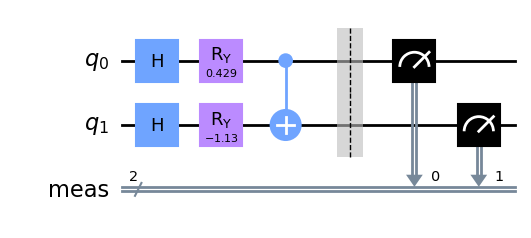

In [19]:
# Menampilkan QC
qc.draw(output='mpl')

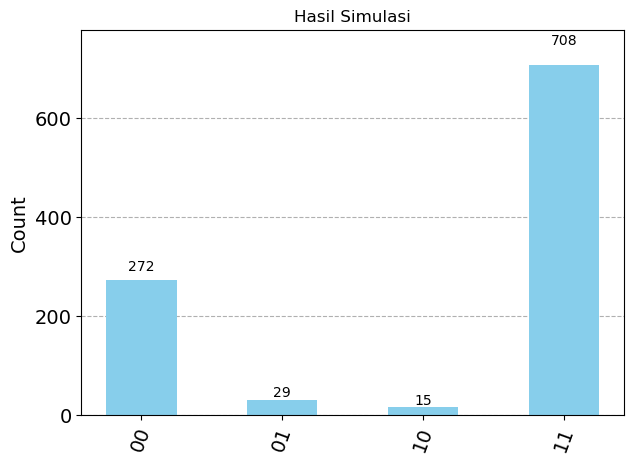

In [20]:
# Plot histogram hasil simulasi
plot_histogram(result.get_counts(), color='skyblue', title="Hasil Simulasi")

- Dalam konteks Quantum Machine Learning, keadaan kuantum yang sering muncul dalam hasil pengukuran mungkin memiliki hubungan dengan output yang diinginkan.